# Periodic boundary conditions

boundary value problem on $\textbf{x}\in\Omega$

$$\nabla^2 u = f(\textbf{x})$$

Neumann boundary condition on $\textbf{x}\in\partial\Omega_{\text{D}}$

$$u = u_{\text{D}}$$

Neumann boundary condition on $\textbf{x}\in\partial\Omega_{\text{N}}$ 

$$\textbf{n}\cdot\nabla u = u_{\text{N}}$$

periodic boundary condition on $\textbf{x}\in\partial\Omega_{\text{M}}\cup\in\partial\Omega_{\text{S}}$

$$u\vert_{\partial\Omega_{\text{M}}} = u\vert_{\partial\Omega_{\text{S}}}$$

In [1]:
import numpy as np
from dolfinx.fem import FunctionSpace

from lucifex.mesh import rectangle_mesh, mesh_boundary
from lucifex.fem import LUCiFExFunction as Function
from lucifex.solver import bvp_solver, BoundaryConditions, OptionsPETSc
from lucifex.viz import plot_colormap, plot_line
from lucifex.utils import cross_section

from lucifex.pde.classic import poisson


Lx = 2.0
Ly = 1.0
mesh = rectangle_mesh(Lx, Ly, 64, 64)
boundary = mesh_boundary(
    mesh, 
    {
        "left": lambda x: x[0],
        "right": lambda x: x[0] - Lx,
        "lower": lambda x: x[1],
        "upper": lambda x: x[1] - Ly,
    },
)

def right_to_left(x: np.ndarray) -> np.ndarray:
    x = x.copy()
    return np.vstack((x[0] - Lx, x[1]))

def upper_to_lower(x: np.ndarray) -> np.ndarray:
    return np.vstack((x[0], x[1] - Ly))

fs = FunctionSpace(mesh, ('P', 1))

## Example: periodic in the $x$-direction ($\partial\Omega_{\text{D}}\cup\partial\Omega_{\text{N}}\neq\varnothing$)

$$c(x=0,y)=c(x=L_x,y)$$

$$c(x,y=0)=c(x,y=L_y)=0$$

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='$x$', ylabel='$y$'>)

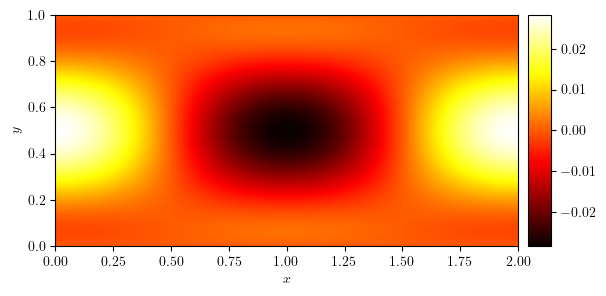

In [2]:
bcs_pbc_x = BoundaryConditions(
    ('periodic', boundary['right'], right_to_left),
    ("dirichlet", boundary['lower', 'upper'], 0.0),
)
f = Function(fs, lambda x: np.cos(2 * np.pi * x[0] / Lx) * np.cos(2 * np.pi * x[1] / Ly), name='f')
u = Function(fs, name='u')
u_solver = bvp_solver(poisson, bcs_pbc_x)(u, f)
u_solver.solve()

plot_colormap(u)

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='$x$', ylabel='$u(y=0.50)$'>)

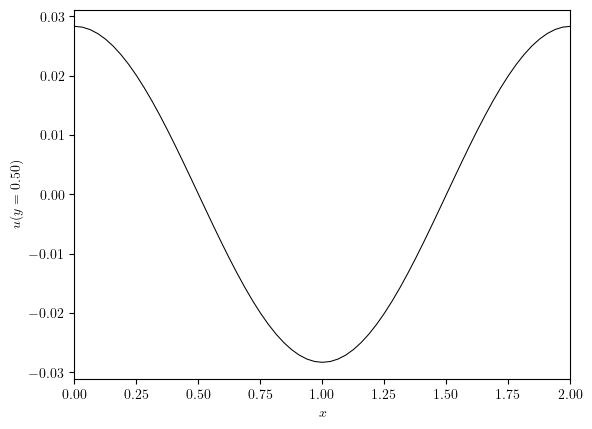

In [3]:
x_axis, ux, y_value = cross_section(u, 'y', 0.5)
plot_line((x_axis, ux), x_label='$x$', y_label=f'${u.name}(y={y_value:.2f})$')

## Example: periodic in the $x$ and $y$ directions ($\partial\Omega_{\text{D}}\cup\partial\Omega_{\text{N}}=\varnothing$)

$$c(x=0,y)=c(x=L_x,y)$$

$$c(x,y=0)=c(x,y=L_y)$$

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='$x$', ylabel='$y$'>)

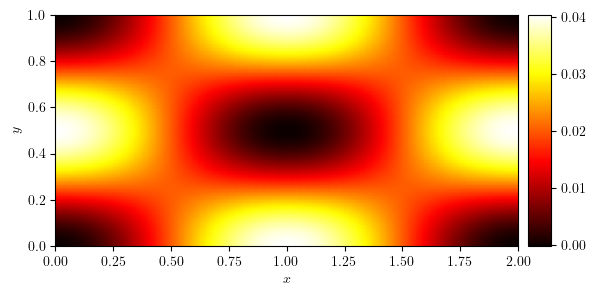

In [3]:
bcs = BoundaryConditions(
    ('periodic', boundary['upper'], upper_to_lower),
    ('periodic', boundary['right'], right_to_left),
)

u = Function(fs, name='u')
f = Function(fs, lambda x: np.cos(2 * np.pi * x[0] / Lx) * np.cos(2 * np.pi * x[1] / Ly), name='f')
u_solver = bvp_solver(poisson, bcs)(u, f)
u_solver.solve()

plot_colormap(u)

## Example: antiperiodic in the $x$-direction

$$c(x=0,y)=-c(x=L_x,y)$$

$$c(x,y=0)=c(x,y=L_y)=0$$

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='$x$', ylabel='$y$'>)

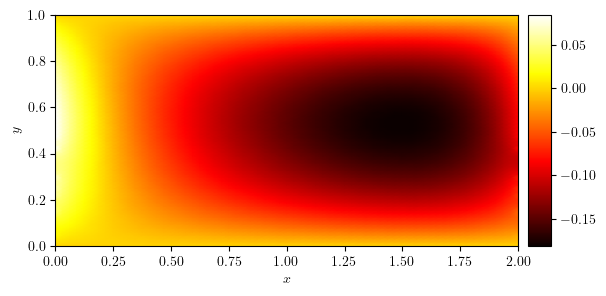

In [4]:
bcs = BoundaryConditions(
    ('antiperiodic', boundary['right'], right_to_left),
    ("dirichlet", boundary['lower', 'upper'], 0.0),
)
f = Function(fs, lambda x: x[0] + x[1] ** 2, name='f')
u = Function(fs, name='u')
u_solver = bvp_solver(poisson, bcs)(u, f)
u_solver.solve()

plot_colormap(u)

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='$x$', ylabel='$u(y=0.50)$'>)

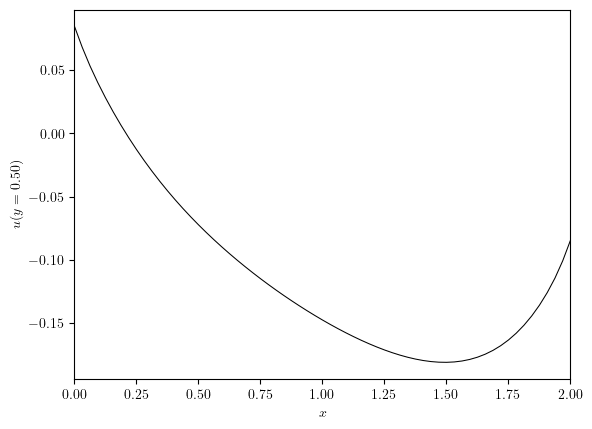

In [5]:
x_axis, ux, y_value = cross_section(u, 'y', 0.5)
plot_line((x_axis, ux), x_label='$x$', y_label=f'${u.name}(y={y_value:.2f})$')

## Example: cross-periodicity

$$c(x,y=L_y)=c(x=0,y)$$

$$c(x=0,y)=c(x=L_x,y)=0$$

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='$x$', ylabel='$y$'>)

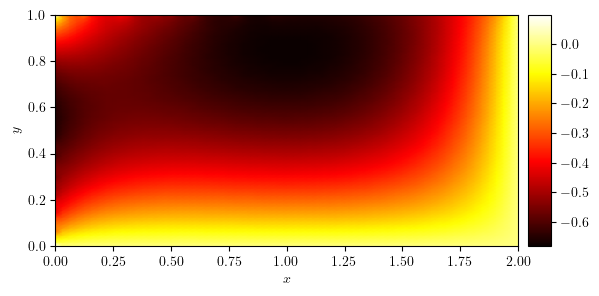

: 

In [ ]:
def upper_to_left(x: np.ndarray) -> np.ndarray:
    return np.vstack((np.zeros_like(x[0]), (Ly / Lx) * x[0]))


f = Function(fs, lambda x: 1.0 + x[0] + x[1] ** 2, name='f')

bcs = BoundaryConditions(
    ('periodic', boundary['upper'], upper_to_left),
    ('dirichlet', boundary['right', 'lower'], 0.0),
)

u = Function(fs, name='u')

petsc = OptionsPETSc('preonly', 'lu', 1e-12, 1e-14)
u_solver = bvp_solver(poisson, bcs, petsc)(u, f)
u_solver.solve()

plot_colormap(u, use_cache=False)